In [1]:
import numpy as np
from sklearn.cluster import SpectralClustering,KMeans
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import matthews_corrcoef,accuracy_score,precision_score,recall_score,confusion_matrix
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import os

In [2]:
outputfolder="figures/"

# HL: evaluate this sample
datatype="HEK293T_WT_directRNA" 
# HL: use this model
modelname="hg38retrain_HEK293T_KO1_chrsplitHEK293T_WT_directRNA_epochs1_100_epochs2_88" 


In [3]:
# HL: transfer from dataden "/umms-kinfai/duolin/ying/reditools2_candidates/"
hash_candidat={}
hash_candidat['AFG-H1_directRNA']='H1-AFG.candidate_sites.tab'
hash_candidat['AFG-H9_directRNA']='H9-AFG.candidate_sites.tab'
hash_candidat["PGC-H1_directRNA"]='H1-PGC.candidate_sites.tab'
hash_candidat["DE-H1_directRNA"]='H1-DE.candidate_sites.tab'
hash_candidat["DE-H9_directRNA"]='H9-DE.candidate_sites.tab'
hash_candidat["GM12878_directRNA"]='GM12878.candidate_sites.tab'
hash_candidat["H1-hESC_directRNA"]='H1-hESC.candidate_sites.tab'
hash_candidat["H9-hESC_directRNA"]='H9-hESC.candidate_sites.tab'
hash_candidat['HEK293T_DKO_directRNA']='HEK293T_WT.candidate_sites.tab'
hash_candidat["HEK293T_WT_directRNA"]='HEK293T_WT.candidate_sites.tab'
hash_candidat["HEK_WT_pass"]='HEK293T_WT.candidate_sites.tab'
candidatefile="/nfs/turbo/umms-kinfai/haorli/20240314_ReDD_result_data/figure2a/reditools2_candidates/"+hash_candidat[datatype]


In [4]:
AG_ratio_per_site={}
shortreadcoverage={}
input = open(candidatefile,'r')
for line in input:
    chr_ = line.split()[0]
    pos_ = line.split()[1]
    chrpos=chr_+"-"+pos_
    if float(line.split("\t")[4]) < 10:
        continue
    AG_ratio_per_site[chrpos]=float(line.split("\t")[3])
    shortreadcoverage[chrpos]=float(line.split("\t")[4])

In [5]:
#REDD
featuredim=5
windowsize=9
inputfolder="/nfs/turbo/umms-kinfai/haorli/20240314_ReDD_result_data/figure2c/ReDD_results/"
modelname = 'hg38_merge9alldata5_noearlystop_run1ep40_run2ep60_negsite_HEK293T_WT_directRNA_epochs5_KOnonw5_withLSTM'

# WT data
datatype="HEK293T_WT_directRNA"
filename=inputfolder+"/"+modelname+"/"+datatype+"_onlycandidate.txt"
input = open(filename)
pos_coverage={}
coverage = {}
cutoff = 0.5#0.5
for line in input:
    score=float(line.split("\t")[-1])
    if score>=cutoff:
       predict_label=1
    else:
       predict_label=0
    
    transid= line.split("\t")[2]
    transpos = line.split("\t")[3]
    chrpos = transid+"-"+transpos
    
    if chrpos not in pos_coverage.keys():
        pos_coverage[chrpos]=predict_label
        coverage[chrpos]=1
    else:
        pos_coverage[chrpos]+=predict_label
        coverage[chrpos]+=1
long_reads_min_coverage = 5
WT_predict_value_all={}
for site in AG_ratio_per_site:   
     if site in pos_coverage:
          if coverage[site] >= long_reads_min_coverage:
              WT_predict_value_all[site]=float(pos_coverage[site]/coverage[site])
                

# DKO data
datatype="HEK293T_DKO_directRNA"
filename=inputfolder+"/"+modelname+"/"+datatype+"_onlycandidate.txt"
input = open(filename)
pos_coverage={}
coverage = {}
cutoff = 0.5#0.5
for line in input:
    score=float(line.split("\t")[-1])
    if score>=cutoff:
       predict_label=1
    else:
       predict_label=0
    
    transid= line.split("\t")[2]
    transpos = line.split("\t")[3]
    chrpos = transid+"-"+transpos
    
    if chrpos not in pos_coverage.keys():
        pos_coverage[chrpos]=predict_label
        coverage[chrpos]=1
    else:
        pos_coverage[chrpos]+=predict_label
        coverage[chrpos]+=1
long_reads_min_coverage = 5
DKO_predict_value_all={}
for site in AG_ratio_per_site:   
     if site in pos_coverage:
          if coverage[site] >= long_reads_min_coverage:
              DKO_predict_value_all[site]=float(pos_coverage[site]/coverage[site])

In [6]:
true_list=[]
WT_predict_list = []
DKO_predict_list = []
coords_list = []
for key in WT_predict_value_all:#1259
    true_list.append(AG_ratio_per_site[key])
    WT_predict_list.append(WT_predict_value_all[key])
    if key in DKO_predict_value_all:
        DKO_predict_list.append(DKO_predict_value_all[key])
    else:
        DKO_predict_list.append(0)
    coords_list.append(key)
true_list,WT_predict_list,DKO_predict_list,coords_list = np.array(true_list),np.array(WT_predict_list),np.array(DKO_predict_list),np.array(coords_list)


In [7]:
# export to csv
import pandas as pd
from pathlib import Path
df = pd.DataFrame([coords_list,true_list,WT_predict_list,DKO_predict_list]).T
df.columns = ['Site','truth','ReDD_WT','ReDD_DKO']
Path('plot_data').mkdir(exist_ok=True,parents=True)
df.to_csv('plot_data/site_ratio.tsv',sep='\t',index=False)

In [8]:
num_bins = 5
binsize=1/num_bins
def binize_list(true_list,predict_list):
    ratio_list = np.arange(0,1,binsize) #np.random.uniform(0.0, 1.0, 30)
    ratio_list.sort()
    sample_size=[]
    AG_ratios_bin=[]
    predict_ratio_bin = []
    ratio_bin_list=[]
    for index in range(len(ratio_list)):
        start = ratio_list[index]
        end = start+binsize
        index_start_end = np.where((true_list<=end) &(true_list>start))[0]
        if(len(index_start_end)>1):
            ratio_bin_list.append(start)
            AG_ratios_bin.append(true_list[index_start_end])
            predict_ratio_bin.append(predict_list[index_start_end])
            sample_size.append(len(predict_list[index_start_end]))
    return AG_ratios_bin,predict_ratio_bin,sample_size


In [9]:
WT_AG_ratios_bin,WT_predict_ratio_bin,WT_sample_size = binize_list(true_list,WT_predict_list)
DKO_AG_ratios_bin,DKO_predict_ratio_bin,DKO_sample_size = binize_list(true_list,DKO_predict_list)


In [10]:
assert (WT_AG_ratios_bin[0] == DKO_AG_ratios_bin[0]).all()

In [11]:
def cal_MAE(AG_ratios_bin,predict_ratio_bin):
    mae=np.abs(np.asarray([np.median(x) for x in AG_ratios_bin])-np.asarray([np.median(x) for x in predict_ratio_bin])).mean()
    return mae

In [12]:
mae = cal_MAE(WT_AG_ratios_bin,WT_predict_ratio_bin)

In [13]:
mae

0.07986531986531986

In [20]:
np.mean(DKO_predict_list)

0.038493198227449864

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

<Figure size 2000x2000 with 0 Axes>

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

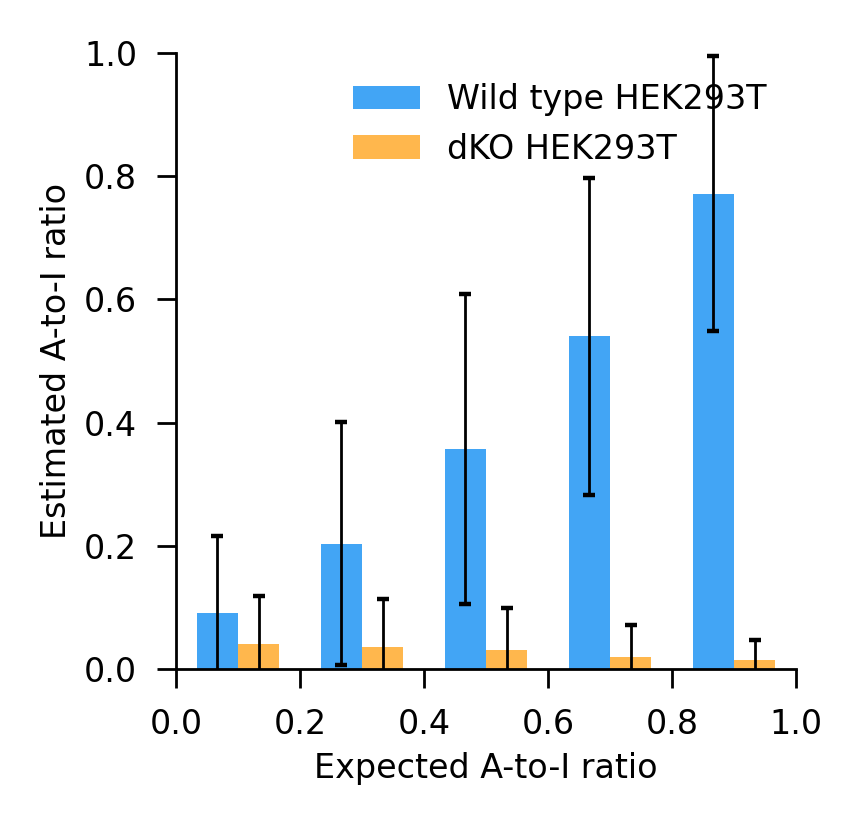

In [14]:
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib as mpl
plt.style.use('ggplot')
plt.style.use('~/tidyplot.mplstyle')
colors=['#42a5f5','#66bb6a','#ffb74d','#81c784']
second_colors =['#1565c0','#2e7d32','#ef6c00','#81c784']
plt.clf()
mpl.rcParams['figure.figsize'] = 2,2
f, ax2 = plt.subplots(1, 1)
plt.subplots_adjust(wspace=None, hspace=0.4)

num_methods = 3
offset = binsize/num_methods/2+binsize/num_methods/2
error = [np.std(x) for x in WT_predict_ratio_bin]

ax2.bar([binsize*i+offset for i in range(num_bins)], [np.mean(x) for x in WT_predict_ratio_bin],   yerr=error, width=binsize/num_methods,align='center', ecolor='black', capsize=10,error_kw=dict(lw=0.5, capsize=1, capthick=0.8),label="Wild type HEK293T",color=colors[0])
error = [np.std(x) for x in DKO_predict_ratio_bin]
ax2.bar([binsize*i+binsize/num_methods+offset for i in range(num_bins)], [np.mean(x) for x in DKO_predict_ratio_bin],  yerr=error, width=binsize/num_methods,align='center', ecolor='black', capsize=10,error_kw=dict(lw=0.5, capsize=1, capthick=0.8),label="dKO HEK293T",color=colors[2])

ax2.set_xlabel('Expected A-to-I ratio') #\nTotal number of candidate sites='+str(len(coverage))+"(>"+str(coverage_cutoff)+":"+str(hi_coverage_site_num)+")")
ax2.set_ylabel('Estimated A-to-I ratio')
ax2.set_xticks(np.arange(0,1+binsize,binsize))
ax2.set_yticks(np.arange(0,1+binsize,binsize))
ax2.set(xlim=(0, 1), ylim=(0, 1))
ax2.get_xaxis().set_visible(True)
ax2.set_xticks([i/num_bins for i in range(num_bins+1)])
# ax2.plot([0, 1], [0, 1], ls="--",color="black")
ax2.xaxis.set_tick_params(labelbottom=True)
# ax2.set_box_aspect(1)
# plt.subplots_adjust(hspace=0.03,left=0.16)
ax2.legend()
#plt.show()



try:
    os.mkdir(outputfolder+"/"+modelname+"/")
except:
    pass


plt.savefig("barplot.svg")
